## RECANET

добавить Бейзлайны, тифу кнн + топ поп,

TOP PERSONAL BASELINE

Локальный транзакционный датасет.

In [ ]:
!python -V

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/recsys

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.2)

from IPython.display import clear_output
%matplotlib inline

import pandas as pd
import plotly.express as px
import numpy as np
from tqdm import tqdm

tqdm.pandas()

from sklearn.metrics import accuracy_score, roc_auc_score

import torch
from torch import nn
from torch.utils.data import DataLoader
#from torchvision import datasets, transforms

import torch.nn.functional as F
import torch.optim as optim
#import torchvision.transforms as tt

from tqdm.notebook import tqdm
from torchsummary import summary


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
!nvidia-smi

Thu Jan 19 23:06:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.41       Driver Version: 527.41       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   35C    P8    N/A /  72W |    548MiB /  4096MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataloader+dataset

In [18]:
history_len=40
item_embed_size=32
user_embed_size=128

h1 = 128
h2 = 128
h3 = 128
h4 = 128
h5 = 128

In [69]:
from metrics import recall_k, ndcg_k, repeat_score_item, repeat_score_user
from recanet_datasets import PreDataset, RCNDataset, DeviceDataLoader
from recanet_model import ReCaNet

In [6]:
path_train = 'dunnhumby_cj/baskets/train_baskets_sample.csv'
path_test = 'dunnhumby_cj/baskets/test_baskets.csv'
path_val = 'dunnhumby_cj/baskets/valid_baskets.csv'

In [7]:
dataset = PreDataset(path_train,path_val, path_test, dataset='dunnhumby', history_len=history_len)

number of test users: 1498
filtered items: 22923
items: 22924
filtered items: 22923


In [8]:
#train_items,train_users, train_history,train_history2 ,train_labels = dataset.create_train_data()
#train_labels.unique(return_counts=True)

In [9]:
batch_size = 1000

train_dataset = RCNDataset(dataset, mode='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = RCNDataset(dataset, mode='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = RCNDataset(dataset, mode='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Data allready in use


In [10]:
len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset)

(617773, 39433, 44849)

In [11]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [12]:
#LSTM(h2,return_sequences = True)(x14, mask = tf.dtypes.cast(input4, tf.bool))
#x = LSTM(h3)(x, mask = tf.dtypes.cast(input4, tf.bool))


#x = Dense(h4, activation='relu')(x)
#x = Dense(h5, activation='relu')(x)
#output = Dense(1, activation='sigmoid')(x)

In [13]:
#summary(ReCaNet(num_items=duhumby.num_items, item_embed_size=32, num_users=duhumby.num_users, user_embed_size=128,\
#                h1 = 128,h2 = 128,h3 = 128,h4 = 128,h5 = 128).to(device), \
#       input_size=[ (None,1), (None,1), (None, 5), (None, 5)], device=device)

In [14]:
def plot_training(loss_train, loss_val, score_test ,i):
    plt.figure(figsize=(16, 3))
    plt.plot(np.arange(i+1), loss_train, label='Train')
    plt.plot(np.arange(i+1), loss_val, label='Validation')
    plt.xlim(0, i+2)
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    plt.figure(figsize=(16, 3))
    plt.plot(np.arange(i+1), score_test, label='roc_auc_score')
    plt.xlim(0, i+2)
    plt.ylim(0, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [15]:
torch.cuda.empty_cache()

In [75]:
def train(model, epochs):
    torch.cuda.empty_cache()
    #clear_output(wait=True)
    loss_train = []
    loss_val = []
    auc_test = []

    #epoch_recall = []

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters)
    criterion = nn.BCELoss(reduction='mean')

    #user_valid_baskets_df = dataset.valid_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
    #user_valid_baskets_dict = dict(zip( user_valid_baskets_df['user_id'],user_valid_baskets_df['item_id']))
    #test_items, test_users, test_history,test_history2, test_labels = dataset.create_test_data('test')
    #valid_items, valid_users, valid_history,valid_history2 ,valid_labels = dataset.create_test_data('valid')

    
    for i in tqdm(range(epochs)):
        print(f'Epoch {i+1}')
        loss_train_epoch = []
        loss_val_epoch = []
        acc_val_epoch = []

        model.train()
        for x1, x2, x3, x4, y in tqdm(train_loader):
            optimizer.zero_grad()
            y_pred = model(x1, x2, x3, x4)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            loss_train_epoch.append(loss.item())
        
        loss_train.append(np.mean(loss_train_epoch))
        #print(loss_train)
        #print(np.arange(i+1))
       

        #model.eval()
        
        full_y = []
        full_predictions = []
        #pred_scores = []
        for x1, x2, x3, x4, y in val_loader:
            with torch.no_grad():
                y_pred = model(x1, x2, x3, x4)
                loss = criterion(y_pred, y)

                predictions = [round(value) for value in y_pred.flatten().tolist()]
                full_y.extend(y.detach().cpu())
                #pred_scores.extend(y_pred.detach().cpu())
                full_predictions.extend(predictions)

                loss_val_epoch.append(loss.item())
                auc_val_epoch = roc_auc_score(y.cpu(), y_pred.cpu())

        accuracy = accuracy_score(full_y, full_predictions)
        print("Accuracy epoch: %.2f%%" % (accuracy * 100.0))

        loss_val.append(np.mean(loss_val_epoch))
                
        auc_test.append(np.mean(auc_val_epoch))

        # отрисовка графиков
        #clear_output(wait=True)
        plot_training(loss_train, loss_val, score_test=auc_test, i=i)

    #print(epoch_recall)
    #print('Best epoch:', np.argmax(np.array(epoch_recall))) 
    return loss_train, loss_val
     

In [76]:
model = ReCaNet(num_items=dataset.num_items, item_embed_size=item_embed_size, num_users=dataset.num_users, 
                user_embed_size=user_embed_size, history_len = history_len, h1 = h1,h2 = h2, h3 = h3,
                h4 = h4, h5 = h5).to(device)

In [77]:
model

ReCaNet(
  (item_embedding): Embedding(22924, 32)
  (user_embedding): Embedding(1499, 128)
  (fc1): Linear(in_features=160, out_features=128, bias=True)
  (fc2): Linear(in_features=129, out_features=128, bias=True)
  (fc3): LSTM(128, 128)
  (fc4): LSTM(128, 128)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=1, bias=True)
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/618 [00:00<?, ?it/s]

Accuracy epoch: 98.20%


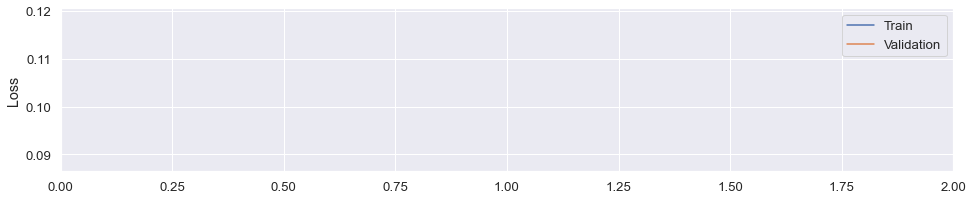

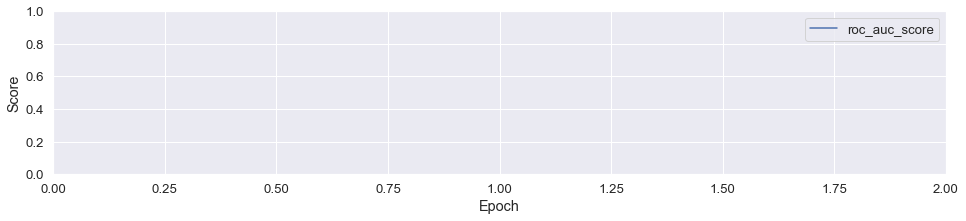

Epoch 2


  0%|          | 0/618 [00:00<?, ?it/s]

Accuracy epoch: 98.20%


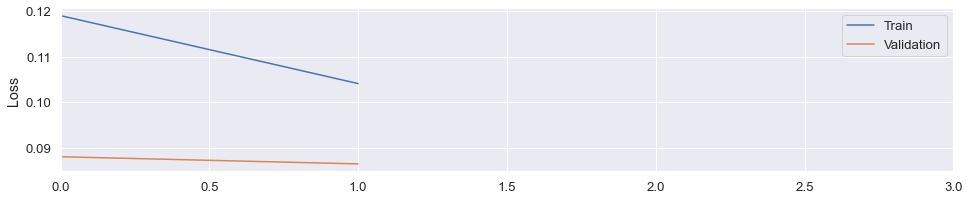

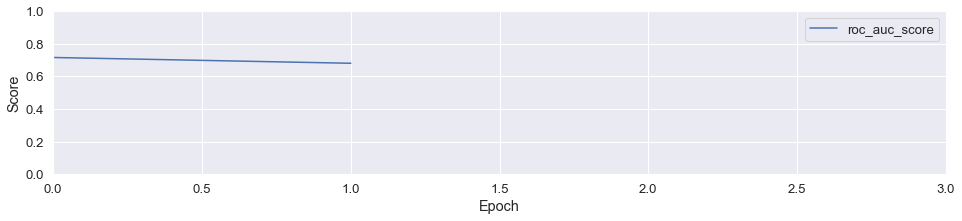

Epoch 3


  0%|          | 0/618 [00:00<?, ?it/s]

Accuracy epoch: 98.20%


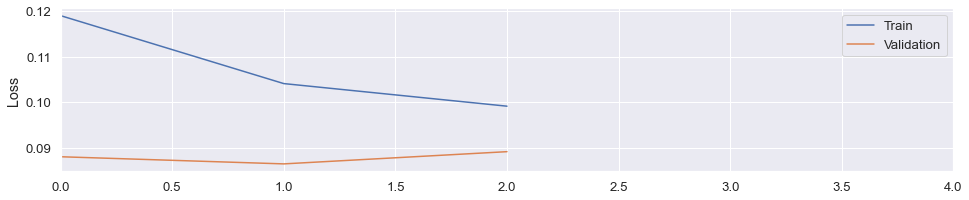

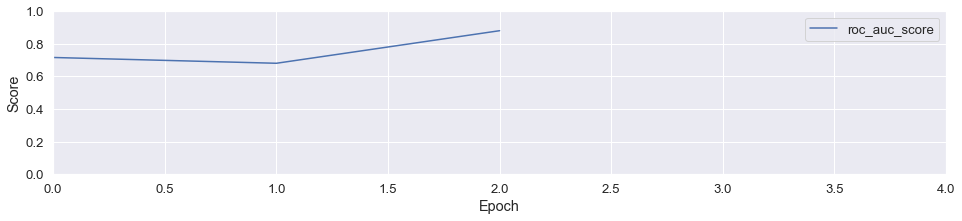

Epoch 4


  0%|          | 0/618 [00:00<?, ?it/s]

Accuracy epoch: 98.20%


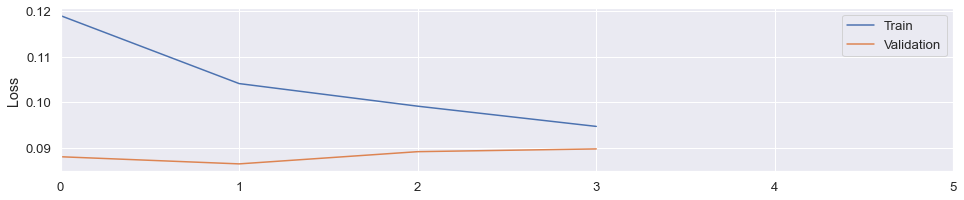

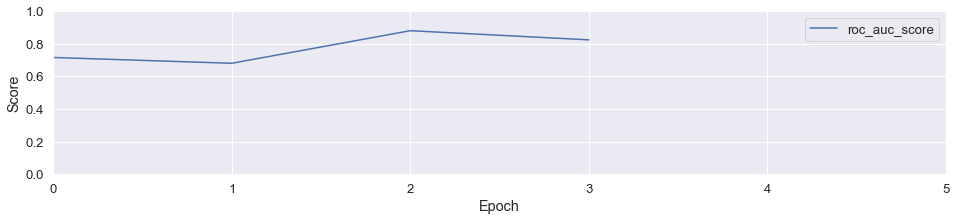

Epoch 5


  0%|          | 0/618 [00:00<?, ?it/s]

Accuracy epoch: 98.20%


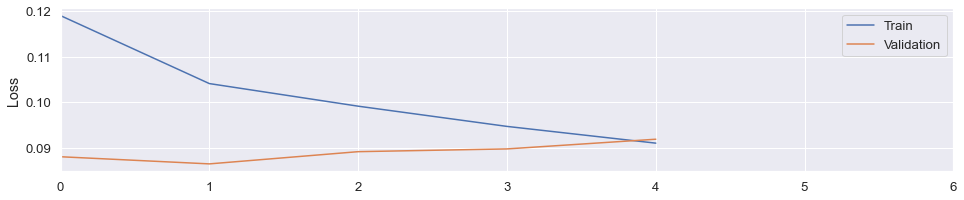

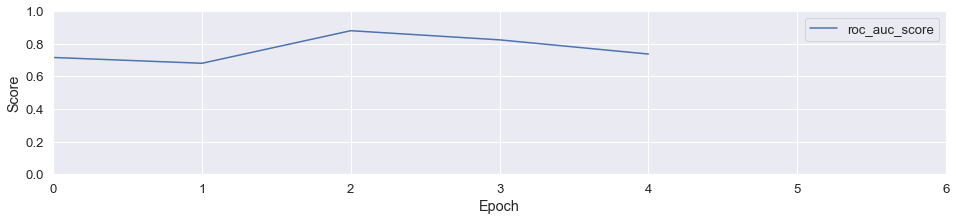

Epoch 6


  0%|          | 0/618 [00:00<?, ?it/s]

Accuracy epoch: 98.20%


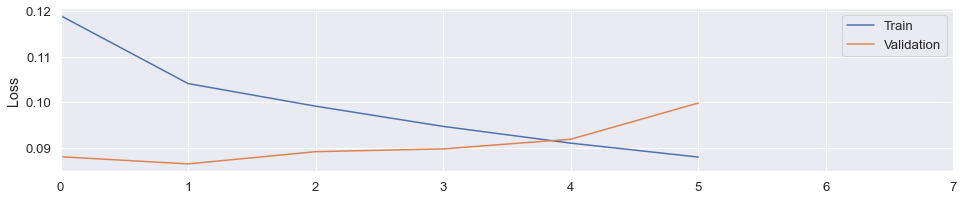

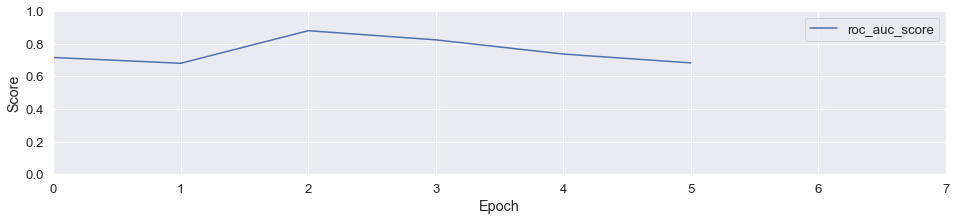

Epoch 7


  0%|          | 0/618 [00:00<?, ?it/s]

Accuracy epoch: 98.18%


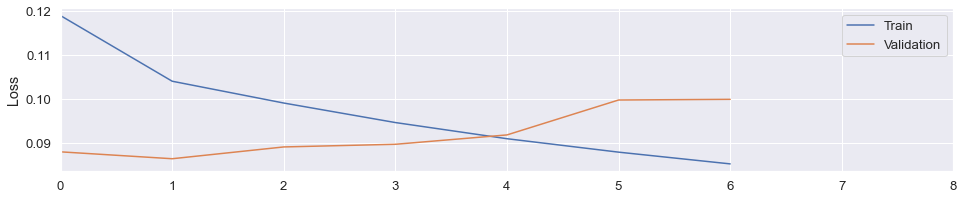

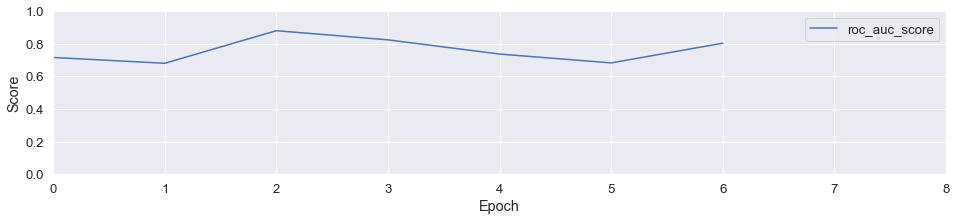

Epoch 8


  0%|          | 0/618 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [78]:
info = train(model, epochs=10)

In [79]:
def predict(model, test_loader):
    test_items, test_users, test_history,test_history2, test_labels = dataset.create_test_data('test')
    preds = []
    pred_scores = []
    for x1, x2, x3, x4, y in tqdm(test_loader):
        with torch.no_grad():
            y_pred = model(x1, x2, x3, x4)
            pred = [round(value) for value in y_pred.flatten().tolist()]
            preds.extend(pred)
            pred_scores.extend(y_pred.flatten().tolist())
            
   
    prediction_baskets = {}
    prediction_scores = {}
    for user in dataset.test_users:
        top_items = []
        if user in dataset.user_id_mapper:
            user_id = dataset.user_id_mapper[user]
            indices = np.argwhere(test_users == user_id)
            item_scores = np.array(pred_scores)[indices].flatten()
            item_ids = test_items[indices].flatten()
            item_score_dic = {}
            for i, item_id in enumerate(item_ids):
                item_score_dic[dataset.id_item_mapper[item_id]] = item_scores[i]
            sorted_item_scores = sorted(item_score_dic.items(), key= lambda x: x[1], reverse = True)
            top_items = [x[0] for x in sorted_item_scores]
            prediction_scores[user] = sorted_item_scores
            
        prediction_baskets[user] = top_items

    return prediction_baskets

In [80]:
test_baskets = pd.read_csv(path_test)
user_test_baskets_df = test_baskets.groupby('user_id')['item_id'].apply(list).reset_index()
user_test_baskets_dict = dict(zip( user_test_baskets_df['user_id'],user_test_baskets_df['item_id']))

user_predictions = predict(model, test_loader)
final_users = set(dataset.test_users).intersection(set(list(user_test_baskets_dict.keys())))
print('predictions ready',len(user_predictions))
print('number of final test users:',len(final_users))
for k in [5,10,20,'B']:
    print(k)
    recall_scores = {}
    ndcg_scores = {}
    zero = 0
    for user in final_users:

        top_items = []
        if user in user_predictions:
            top_items = user_predictions[user]
        else:
            zero+=1

        if k == 'B':
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,len(user_test_baskets_dict[user]))
        else:
            recall_scores[user] = recall_k(user_test_baskets_dict[user],top_items,k)
            ndcg_scores[user] = ndcg_k(user_test_baskets_dict[user],top_items,k)
    #print(zero)
    print('recall:',np.mean(list(recall_scores.values())))
    print('ndcg:',np.mean(list(ndcg_scores.values())))

  0%|          | 0/45 [00:00<?, ?it/s]

predictions ready 1498
number of final test users: 732
5
recall: 0.010070774866718257
ndcg: 0.017718952807840534
10
recall: 0.022084760052009735
ndcg: 0.016060653558719128
20
recall: 0.03172199210441538
ndcg: 0.015439555072738054
B
recall: 0.01538305328620263
ndcg: 0.01578683626111197


In [ ]:
#recall_scores = []
#        for user in user_valid_baskets_dict:
#            top_items = []
#            if user in dataset.user_id_mapper:
#                user_id = dataset.user_id_mapper[user]
#                #print('user_id',user_id, type(user_id))
#                indices = np.argwhere(valid_users == user_id)
#                #print('indices' , indices, type(indices))
#                item_scores = np.array(pred_scores)[indices].flatten()
#                #print('item_scores',item_scores, type(item_scores))
#                item_ids = valid_items[indices].flatten()
#
#                item_score_dic = {}
#                for j, item_id in enumerate(item_ids):
#                    item_score_dic[dataset.id_item_mapper[item_id]] = item_scores[j]
#                sorted_item_scores = sorted(item_score_dic.items(), key= lambda x: x[1], reverse = True)
#                top_items = [x[0] for x in sorted_item_scores]
#            recall_scores.append(recall_k(user_valid_baskets_dict[user],top_items,
#                                              len(user_valid_baskets_dict[user])))
#        epoch_recall.append(np.mean(recall_scores))
        